# DACON 병원 개/폐업 분류 예측 경진대회
[DACON 병원 개/폐업 분류 예측 경진대회](https://dacon.io/competitions/official/9565/overview/description)

## Base Modeling

### 사용 라이브러리

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
import lightgbm as lgbm
from xgboost import XGBClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [16]:
def eval_CM(y_test, y_pred=None, show_cm=0):
    confusion = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    if show_cm:
        print(f"정확도: {acc:.4f}\n정밀도: {precision:.4f}\n재현율: {recall:.4f}\nF1: {f1:.4f}")
    else:
        print(confusion)
        print(f"정확도: {acc:.4f}\n정밀도: {precision:.4f}\n재현율: {recall:.4f}\nF1: {f1:.4f}")

def reg_score(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_true,y_pred))
    MAE = np.mean( np.abs((y_true - y_pred) / y_true) )
    NMAE = mean_absolute_error(y_true, y_pred)/ np.mean( np.abs(y_true) )
    MAPE = np.mean( np.abs((y_true - y_pred) / y_true) ) *100
    R2 = r2_score(y_true, y_pred)
    
    print(f"MSE: {np.round(MSE, 3)}\nRMSE: {np.round(RMSE, 3)}\nMAE: {np.round(MAE, 3)}\nNMAE: {np.round(NMAE, 3)}\nMAPE: {np.round(MAPE, 3)}\nR2: {np.round(R2, 3)}")

### Data Load

In [17]:
train = pd.read_csv("data/pre_train.csv")
test = pd.read_csv("data/pre_test.csv")

train.shape, test.shape

((301, 59), (127, 59))

### 범주형 변수 -> 수치형 변수

`OC, sido, bedCount, instkind, ownerChange`를 변경해줘야함

In [19]:
obj2num = ["OC", "sido", "bedCount", "instkind", "ownerChange"]

In [20]:
# train
temp_arr = []
for col in obj2num:
    temp_arr.append(pd.get_dummies(train[col], drop_first=True))

temp = pd.concat(temp_arr, axis=1)
df_train = pd.concat([temp, train.drop(columns=obj2num, axis=1)], axis=1) 

In [21]:
# test
temp_arr = []
for col in obj2num:
    temp_arr.append(pd.get_dummies(test[col], drop_first=True))

temp = pd.concat(temp_arr, axis=1)
df_test = pd.concat([temp, test.drop(columns=obj2num, axis=1)], axis=1) 

#### Train - Data Split

In [26]:
label = "open"
feature_names = df_train.columns.tolist()
feature_names.remove(label)
feature_names.remove("dental_clinic")
feature_names.remove("경상도")
feature_names.remove("광주")

In [31]:
df_test.drop(columns="제주도", axis=1, inplace=True)

In [61]:
df_test["employee1"] = df_test["employee1"].str.replace(",","").astype("float")
df_test["employee2"] = df_test["employee2"].str.replace(",","").astype("float")

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train[feature_names], df_train[label], test_size=0.15, stratify=df_train[label])

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_valid: {X_valid.shape}\ny_valid: {y_valid.shape}")

X_train: (255, 72)
y_train: (255,)
X_valid: (46, 72)
y_valid: (46,)


#### Random Forest

In [64]:
clf_rf = RandomForestClassifier()

clf_rf.fit(X_train, y_train)

pred_rf = clf_rf.predict(X_valid)

In [65]:
eval_CM(y_valid, pred_rf, 1)

정확도: 0.9565
정밀도: 0.9565
재현율: 1.0000
F1: 0.9778


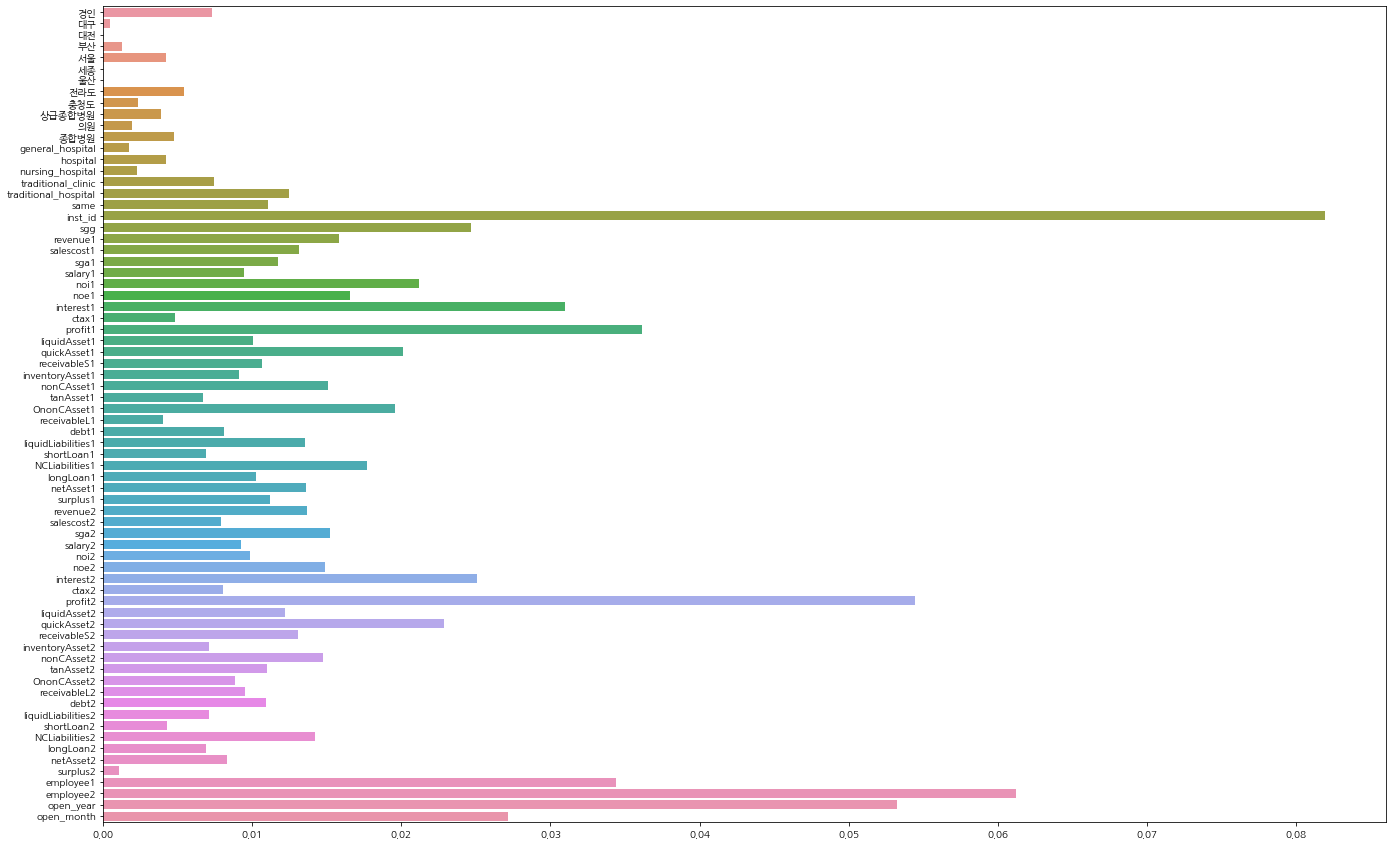

In [66]:
plt.figure(figsize=(23, 15))
_ = sns.barplot(x=clf_rf.feature_importances_, y=clf_rf.feature_names_in_)
plt.show()

#### XGBoost

In [67]:
clf_xgb = XGBClassifier()

clf_xgb.fit(X_train, y_train)

pred_xgb = clf_xgb.predict(X_valid)

[20:22:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [68]:
eval_CM(y_valid, pred_xgb, 1)

정확도: 0.9565
정밀도: 0.9565
재현율: 1.0000
F1: 0.9778


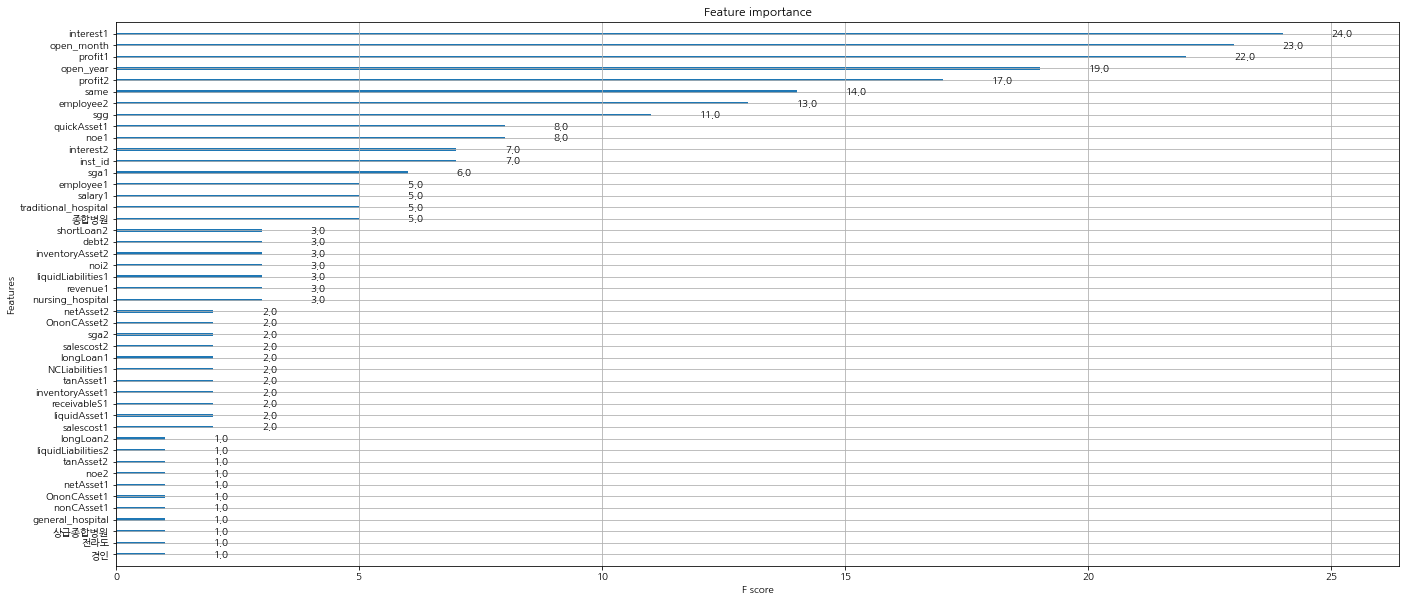

In [69]:
_ = xgb.plot_importance(clf_xgb)
fig = _.figure
fig.set_size_inches(23, 10)

#### LGBM

In [70]:
clf_lgbm = LGBMClassifier()

clf_lgbm.fit(X_train, y_train)

pred_lgbm = clf_lgbm.predict(X_valid)

In [71]:
eval_CM(y_valid, pred_lgbm, 1)

정확도: 0.9348
정밀도: 0.9556
재현율: 0.9773
F1: 0.9663


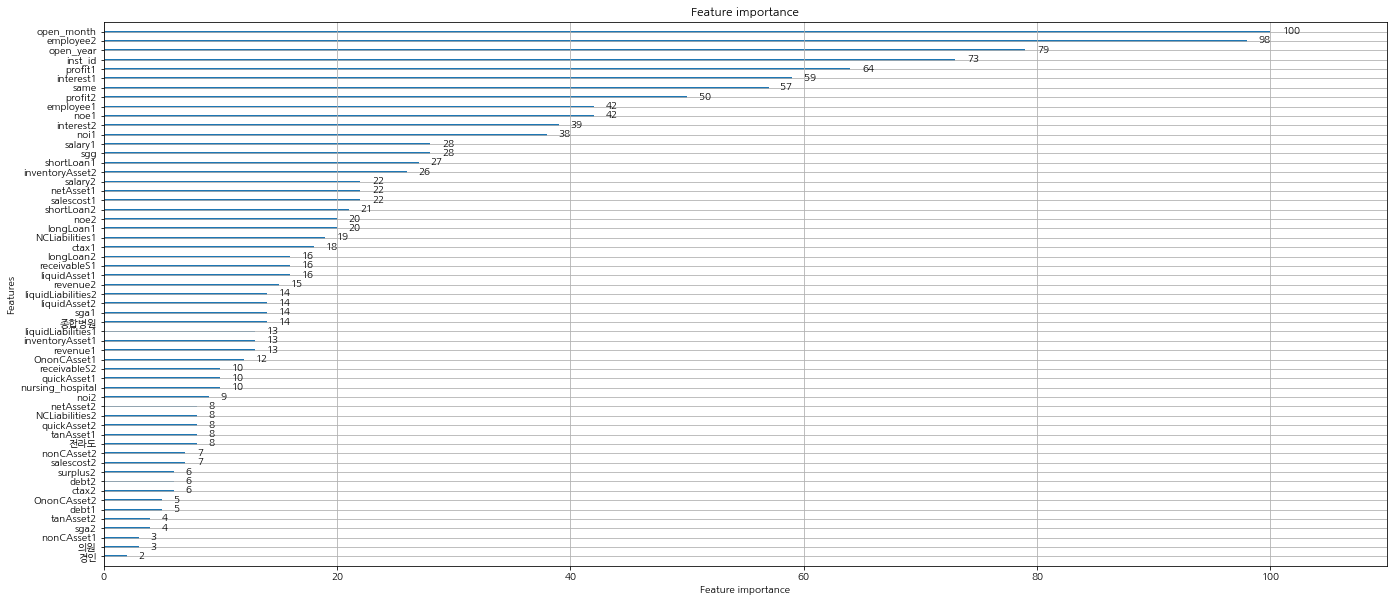

In [72]:
_ = lgbm.plot_importance(clf_lgbm, figsize=(23, 10))

### 제출

In [73]:
sub = pd.read_csv("data/submission_sample.csv")
sub.shape

(127, 2)

In [74]:
sub.head(3)

,inst_id,OC
0,2,0
1,5,0
2,6,0


#### Random Forest

In [79]:
sub["OC"] = clf_rf.predict(df_test)
sub.to_csv("sub_rf.csv", index=False)

public: 0.873015873 / private: 0.828125

#### XGBoost

In [78]:
sub["OC"] = clf_xgb.predict(df_test)
sub.to_csv("sub_xgb.csv", index=False)

public: 0.873015873 / private: 0.828125

#### LGBM

In [77]:
sub["OC"] = clf_lgbm.predict(df_test)
sub.to_csv("sub_lgbm.csv", index=False)

public: 0.873015873 / private: 0.84375

#### Stacking

In [80]:
sub["OC"] = (0.25*clf_rf.predict(df_test)) + (0.25*clf_xgb.predict(df_test)) + (0.5*clf_lgbm.predict(df_test))
sub.to_csv("sub_stacking.csv", index=False)